In [3]:
import pyvisa
import numpy as np
import tables as pt
import matplotlib.pyplot as plt  
import csv
import datetime, time

rm = pyvisa.ResourceManager("@py")
ports = rm.list_resources()
device = rm.open_resource("ASRL/dev/cu.usbmodem11101::INSTR", read_termination="\r\n", write_termination="\n")
print(ports,device.query("*IDN?"))


('ASRL/dev/cu.RichardHP::INSTR', 'ASRL/dev/cu.Bluetooth-Incoming-Port::INSTR', 'ASRL/dev/cu.usbmodem11101::INSTR') Arduino VISA firmware v0.2


## Execute time-based measurement
I first make a heartbeat signal, hereafter I make a sinusoidal signal.

In [5]:
Tbegin = time.time()
Tend = Tbegin+10
T = Tbegin
while T < Tend:
    device.query(f"OUT:CH0 {1022}")
    time.sleep(.1)
    device.query("OUT:CH0 0")
    time.sleep(.1)
    device.query(f"OUT:CH0 {1022}")
    time.sleep(.1)
    device.query("OUT:CH0 0")
    time.sleep(1)
    T=time.time()
device.query("OUT:CH0 0")

T = Tbegin
while T < Tend:
    xlist = np.arange(0,2*np.pi,0.01)
    for i in range(len(xlist)):
        device.query(f"OUT:CH0 {int(1023*np.abs(np.sin(xlist[i])))}")
        time.sleep(.005)
    T=time.time()
device.query("OUT:CH0 0")

'0'

## Convert Volt to Binary
Here I convert Volt (3.3 Volt max) to a 10 bit number. The exact scaling relation is unknown, I assume a linear scaling, y = ax+b with b=0, i.e. no voltage offset.

From row 8th onward I put an outward voltage on channel 0 ranging from 0-1023, I measure the voltage in channel 0, 1 and 2.

 * Channel 0:
 * Channel 1:
 * Channel 2:

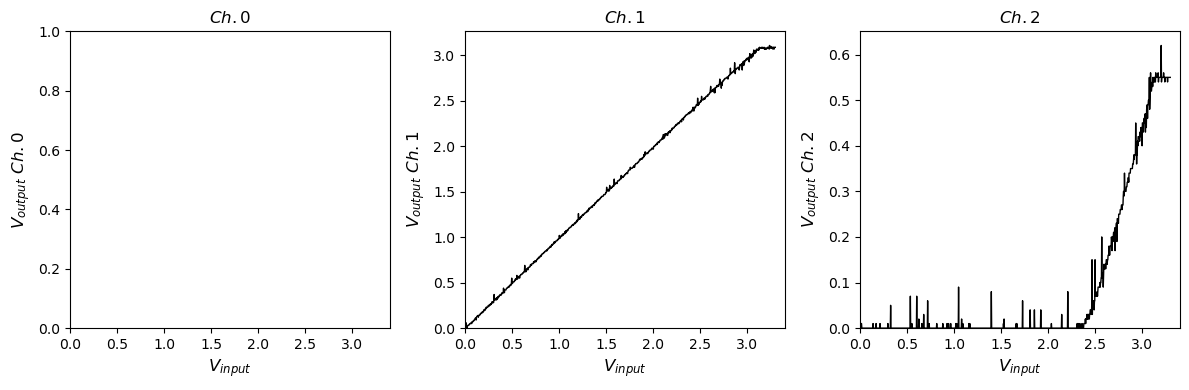

In [8]:
def volt_adc(number):
    v = np.asarray(number)*3.3/1024
    return v
def adc_volt(number):
    adc= int(np.asarray(number)*1024/3.3)
    return adc

V0list,V1list,V2list =[],[],[]
for i in range(1024):
    device.query(f"OUT:CH0 {i}")
    V2list.append(float(device.query("MEAS:CH2:VOLT?")))
    V1list.append(float(device.query("MEAS:CH1:VOLT?")))

fig,axes=plt.subplots(1,3,figsize=(12,4))
# axes[0].plot(volt_adc(range(1024)),np.asarray(V0list), c='black',lw=1)
axes[1].plot(volt_adc(range(1024)),V1list,c='black',lw=1)
axes[2].plot(volt_adc(range(1024)),V2list,c='black',lw=1)
for i in range(3):
    axes[i].set_xlim(0,3.4)
    axes[i].set_ylim(0,None)
    axes[i].set_title(f"$Ch. {i}$", fontsize=12)
    axes[i].set_xlabel(r"$V_{input}$", fontsize=12)
    axes[i].set_ylabel(r"$V_{output}$ " + f"$Ch. {i}$", fontsize=12)
plt.tight_layout()


In [ ]:
import os
import sys

measurement = "blauwe_led_11"
if os.path.isfile(f"LED_curve_m{measurement}.csv") == True:
    print('File excists',os.path.isfile(f"LED_curve_m{measurement}.csv"))
else:
    with open(f"LED_curve_m{measurement}.csv",'w') as file:
        wr=csv.writer(file)
        Tbegin = time.time()
        
        Vinput,tlist = [],[]
        V0list,V1list,V2list = [],[],[]
        volt=0
        
        seconds = time.time()
        local_time = time.ctime(seconds)

        wr.writerow([str(local_time),"Experiment LED arduino 33IoT"])
        wr.writerow(["time(s)", "Vinput(V)", "V0","V1","V2"])

        while volt<3.3:
            V_input, V2,V1,V0 = device.query(f"OUT:CH0 {adc_volt(volt)}"),float(device.query("MEAS:CH2:VOLT?")),float(device.query("MEAS:CH1:VOLT?")),float(device.query("MEAS:CH0:VOLT?"))
            # print(V_input,V0,V1,V2)
            tlist.append(time.time()-Tbegin)
            Vinput.append(V_input)
            V0list.append(V0)
            V1list.append(V1)
            V2list.append(V2)
            wr.writerow([time.time()-Tbegin,V_input, V0,V1,V2])
            volt+=0.003
        
device.query("OUT:CH0 1000")
time.sleep(.5)
device.query("OUT:CH0 0")



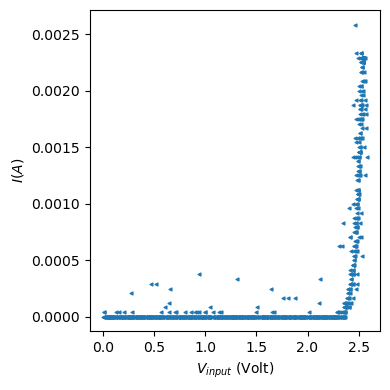

In [9]:
weerstand = 240
Vled = np.asarray(V1list)-np.asarray(V2list)
Stroomsterkte = np.asarray(V2list)/weerstand
fig,axes=plt.subplots(1,1,figsize=(4,4))
axes.set_xlabel('$V_{input}$ (Volt)')
axes.set_ylabel('$I (A)$')
axes.scatter(Vled,Stroomsterkte,s=4,marker='<')
plt.tight_layout()

In [1]:
#3.2
class Particle:
    def __init__(self,name,spin):
        self.name=name
        self.spin=spin
        
    def is_up_or_down(self):
        if self.spin==0.5:
            return('up')
        elif self.spin==-0.5:
            return('down')
        else:
            print('error, spin not (-)1/2')
        
    def flip(self):
        self.spin= self.spin*-1
        return (self.spin)
    
proton = Particle('mooi proton', 0.5)

quark = Particle('mooi quark', 0.4)
print(proton.is_up_or_down())
print(proton.flip())
print(proton.is_up_or_down())
proton.name
quark.name
quark.flip()
quark.is_up_or_down()

up
-0.5
down
error, spin not (-)1/2


In [85]:
import pyvisa
import numpy as np
import matplotlib.pyplot as plt  
import csv
import datetime, time
import os
import sys

from arduino_device import ArduinoVISADevice, list_devices

print(list_devices())
port = "ASRL/dev/cu.usbmodem1101::INSTR"

device = ArduinoVISADevice(port=port)
print(device)
# ch0_input = device.set_output_value(channel=0,value=512)
# ch0_value = device.get_input_value(channel=0)
# ch0_volt = device.get_input_volt(channel=1)

# print(ch0_input,ch0_value)
        

('ASRL/dev/cu.RichardHP::INSTR', 'ASRL/dev/cu.Bluetooth-Incoming-Port::INSTR', 'ASRL/dev/cu.usbmodem1101::INSTR')


In [51]:
print(device.query(f"OUT:CH0 1025"),float(device.query(f"OUT:CH0?"))%1023)
# device.query(f"OUT:CH0:VOLT?")

1025 2.0


## Inhoudelijke training en didactische training Di 1 Nov.
